# Clustering Football Players Using KMeans Clustering

The goal of this project is to show how to identify the optimum number of clusters to use for a given data using the silhouette scores and also the WCSS method(Within-Clusters Sum of Squares) or elbow method.

The data to be clustered will be above 2 dimensions and so to visualise the clusters, the data will be reduced to two dimensions using Principal Component Analysis(PCA).

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from typing import Union
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)


In [2]:
data = {}

data["shooting"] = pd.read_csv("shooting.csv")
data["passing"] = pd.read_csv("passing.csv")
data["gca"] = pd.read_csv("gca.csv")
data["defense"] = pd.read_csv("defense.csv")
data["goalkeeping"] = pd.read_csv("goalkeeping.csv")

In [3]:
def plot_silhoutte(X: Union[np.ndarray, pd.DataFrame], range_n_clusters: list[int]) -> plt.figure:
    """
    Function to perform silhoutte analysis on different KMeans clusters
    """

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, init="k-means++", random_state=1)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

    #     # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        pca = PCA(n_components=2) # reduce the data to 2 dimensions
        data_2d = pca.fit_transform(X)
        ax2.scatter(
            data_2d[:, 0], data_2d[:, 1], marker="o", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )


        # Labeling the clusters
        centers = clusterer.cluster_centers_
        centers_2d = pca.transform(centers)
        # Draw white circles at cluster centers
        ax2.scatter(
            centers_2d[:, 0],
            centers_2d[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )

        for i, c in enumerate(centers_2d):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

In [4]:
def plot_wcss(X: Union[np.ndarray, pd.DataFrame]) -> plt.figure:
    """
    Function to perform elbow analysis on KMeans clusters
    """
    wcss = []
    
    for i in range(1, 11):
        clusterer = KMeans(n_clusters=i, init="k-means++", random_state=1) #random state for reproducibility
        clusterer.fit(X)
        wcss.append(clusterer.inertia_) # clusterer.inertia gives the distance betweem the centroids and the other points.
    
    x = np.arange(1, 11)
    y = wcss
    plt.plot(x, y)
    plt.title("Elbow Method Evaluation For KMeans")
    plt.xlabel("No of Clusters")
    plt.ylabel("WCSS")
    plt.show()
    
    

## Clustering Shooting and Goal Creating Action Data.

The gca dataset and the shooting dataset are going to be merged and then filtered for players who are forwards only since players who are forwards are most involved in creating and scoring goals.

The players will be clustered on how many 90 mins they played, goals scored, shots per 90, shot on target per 90, non penalty expected goals, goal creating action per 90 and shot creating action per 90. All pf which are important metrics for a forward player.

In [5]:
fw_data = data["shooting"].merge(data["gca"], how="inner", on="player")
fw_data.columns = fw_data.columns.str.replace("_x", "")

In [6]:
fw_cols = ["90s", "sh/90", "sot/90", "gls", "npxg","sca90", "gca90"]

It is important to scale the data when performing a clustering analysis. A minmax scaler will be used to scaled the data

In [7]:
scaler = MinMaxScaler()
X_fw = (fw_data
        .query("pos == 'FW'")
       [fw_cols]
       )
X_fw = scaler.fit_transform(X_fw)

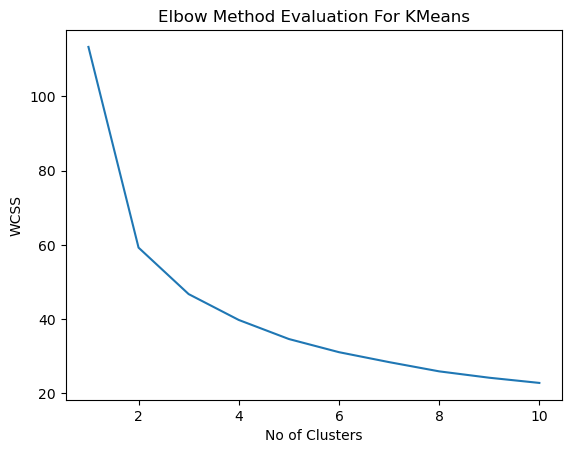

In [8]:
plot_wcss(X_fw)

Using the WCSS/elbow method, it seems the optimal number of clusters for the fowards data the data is 3.
The silhouette plot is going to be visualised as well as the clusters to see if it matches with the WCSS plot.

For n_clusters = 2 The average silhouette_score is : 0.4371821141542552
For n_clusters = 3 The average silhouette_score is : 0.3300307327963268
For n_clusters = 4 The average silhouette_score is : 0.3295290303769851
For n_clusters = 5 The average silhouette_score is : 0.28184699386556294
For n_clusters = 6 The average silhouette_score is : 0.2624874485891169
For n_clusters = 7 The average silhouette_score is : 0.2704773363303577
For n_clusters = 8 The average silhouette_score is : 0.25572760211548873


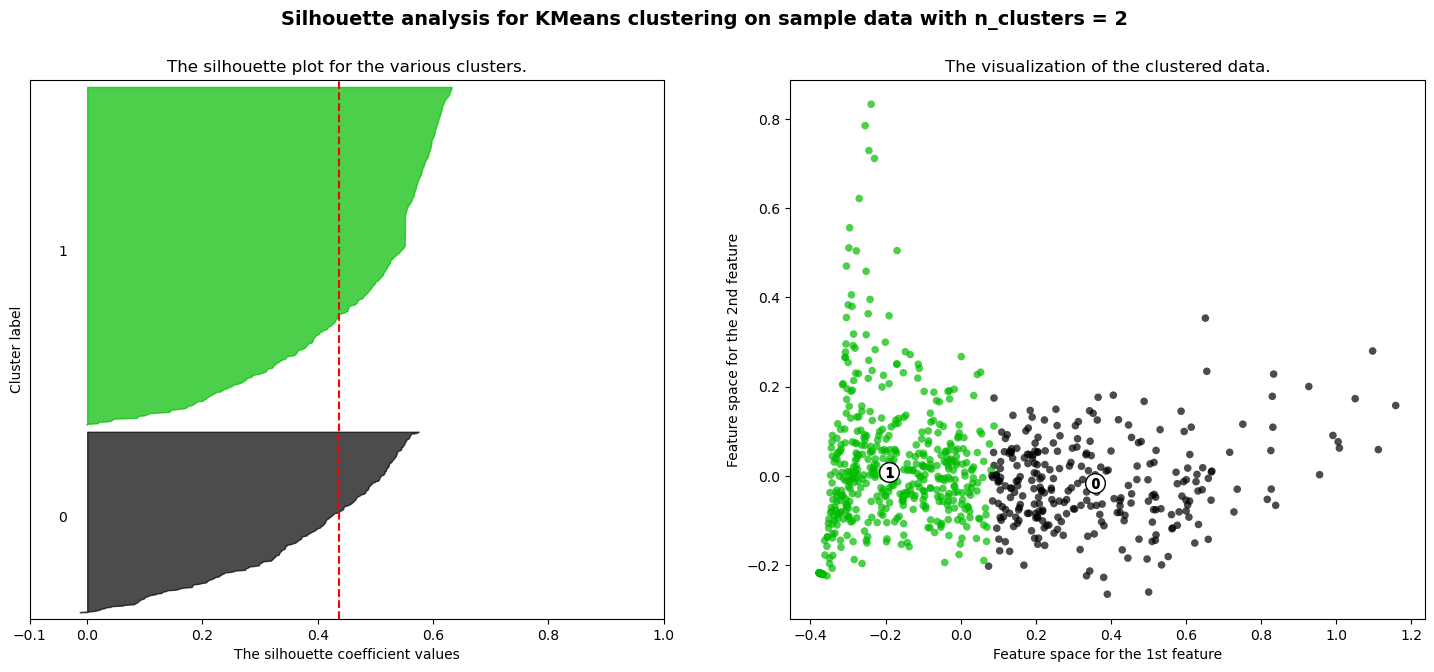

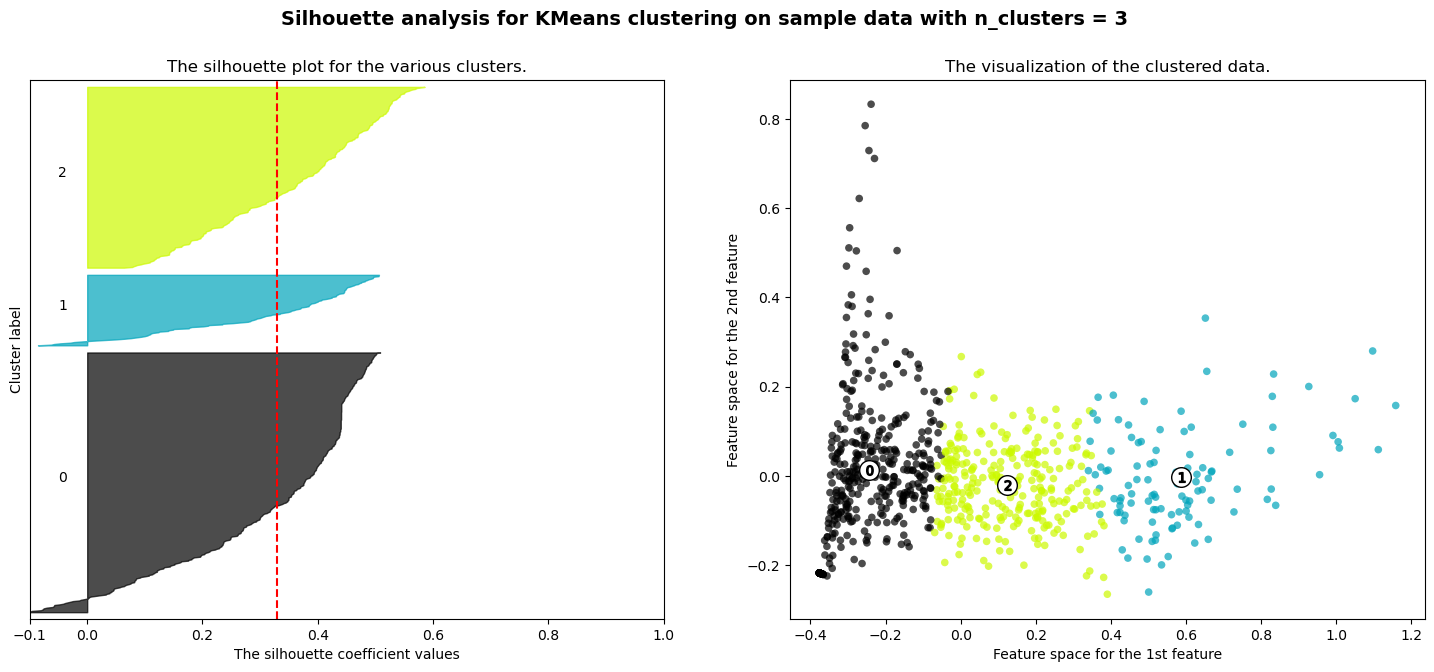

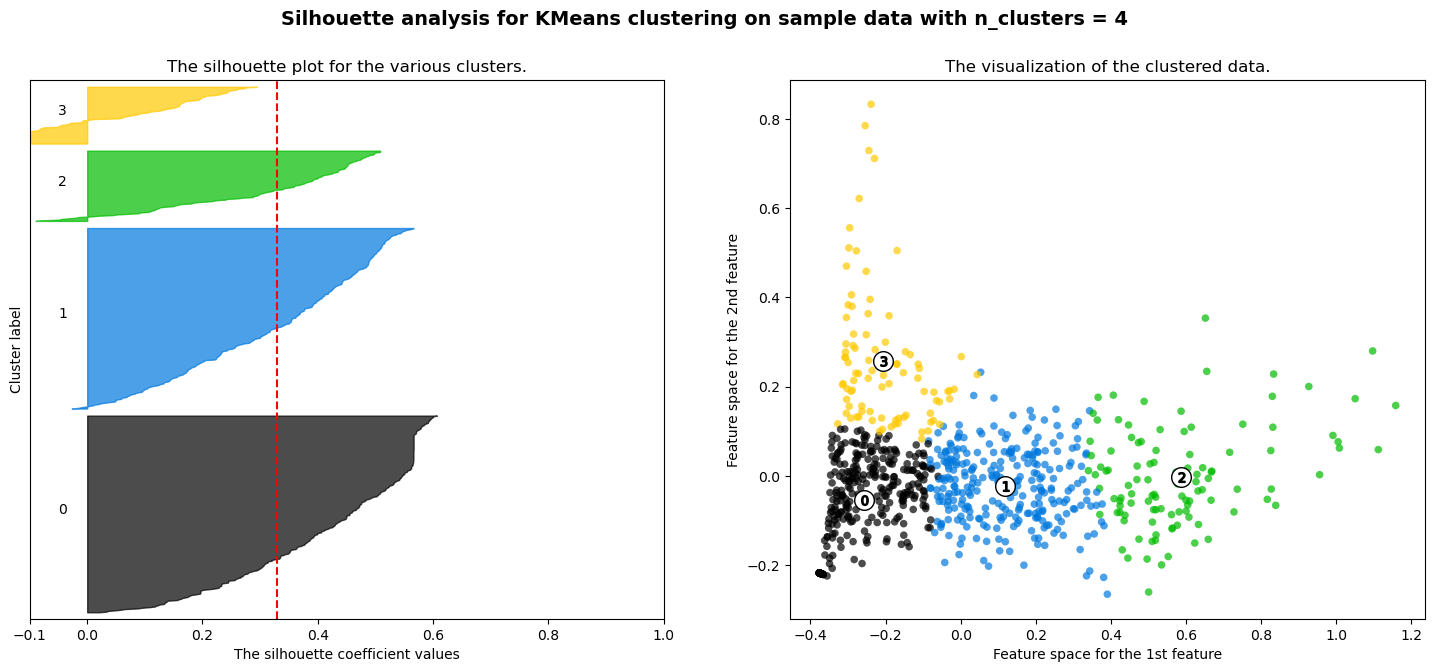

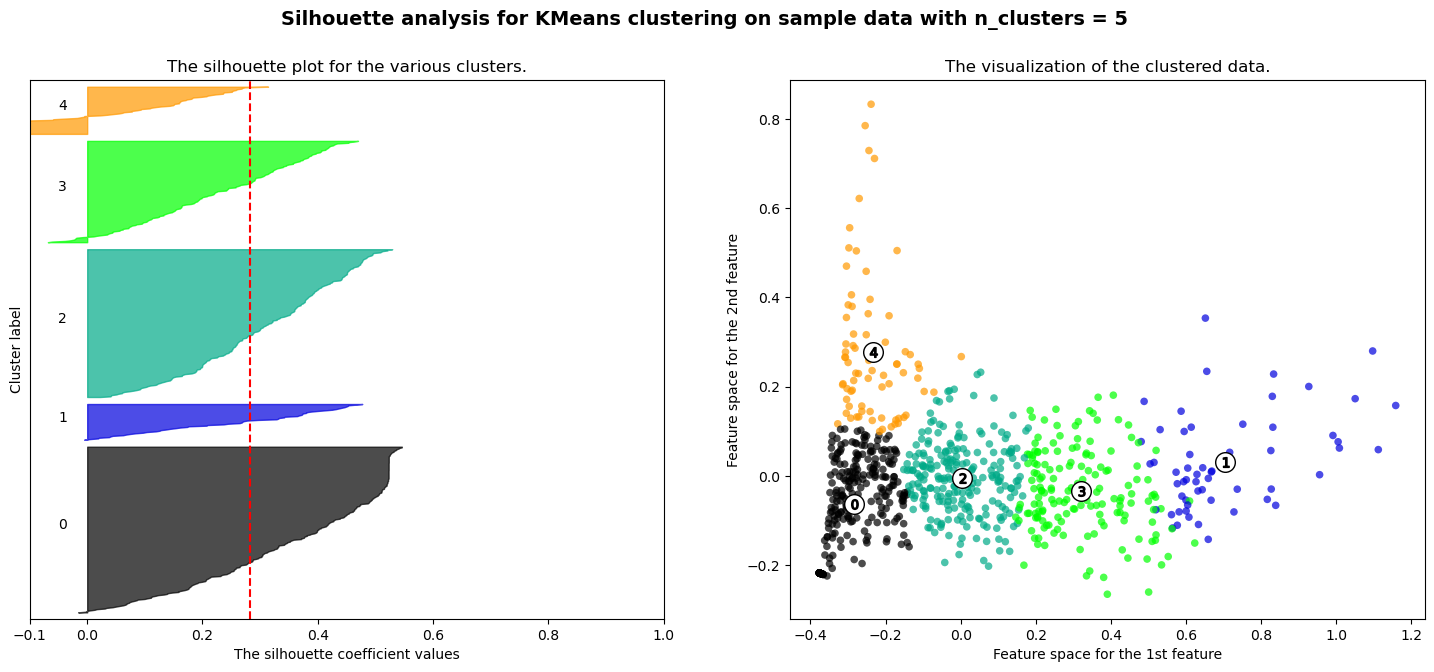

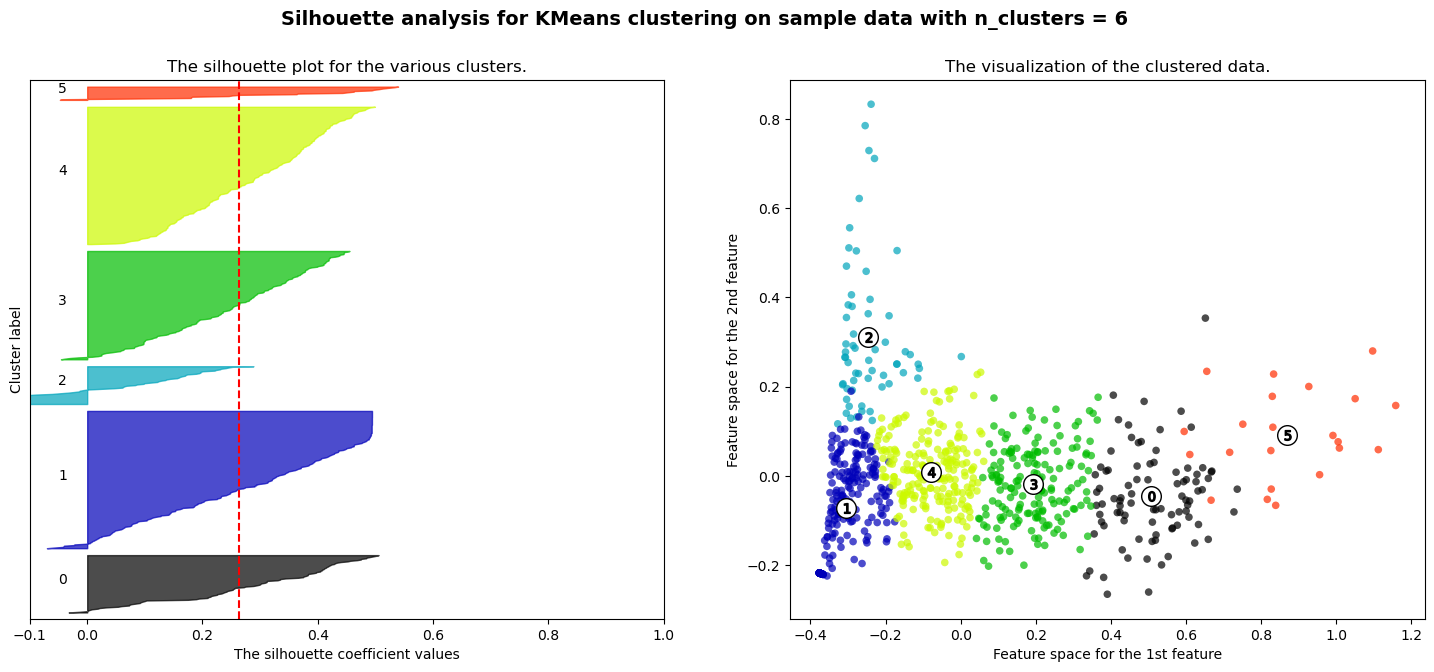

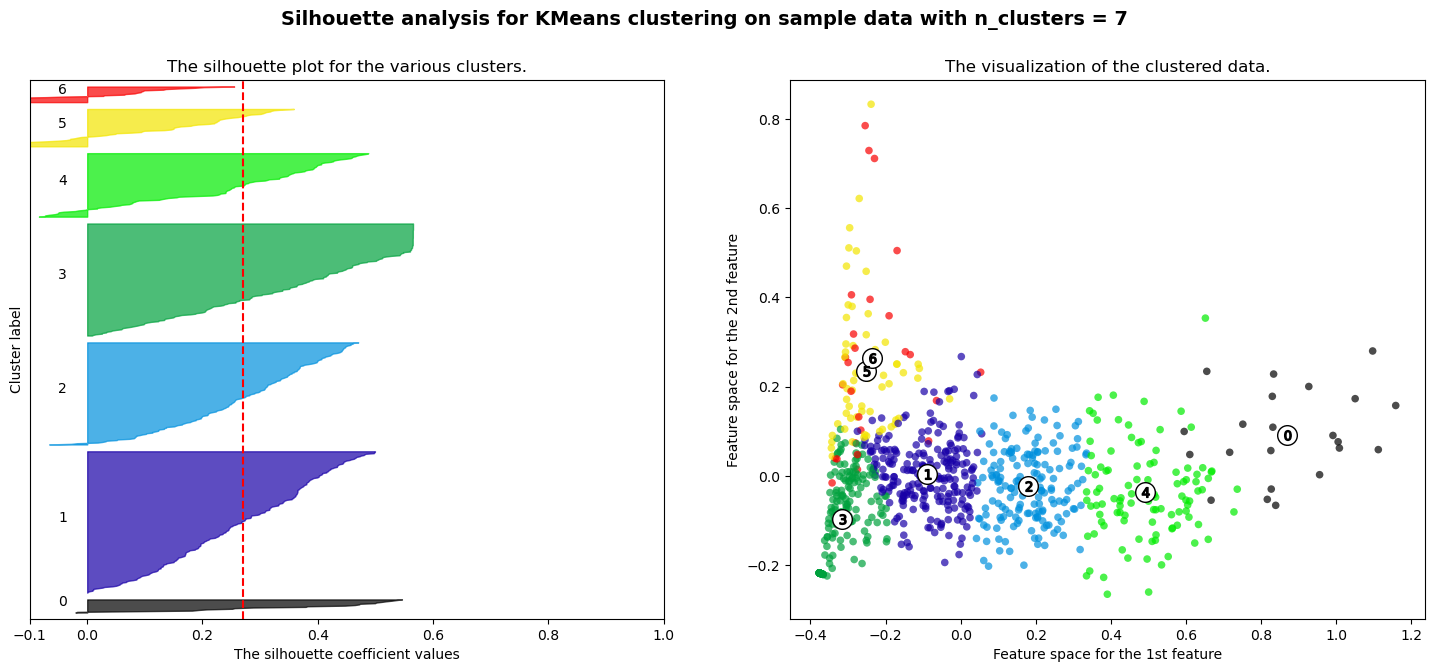

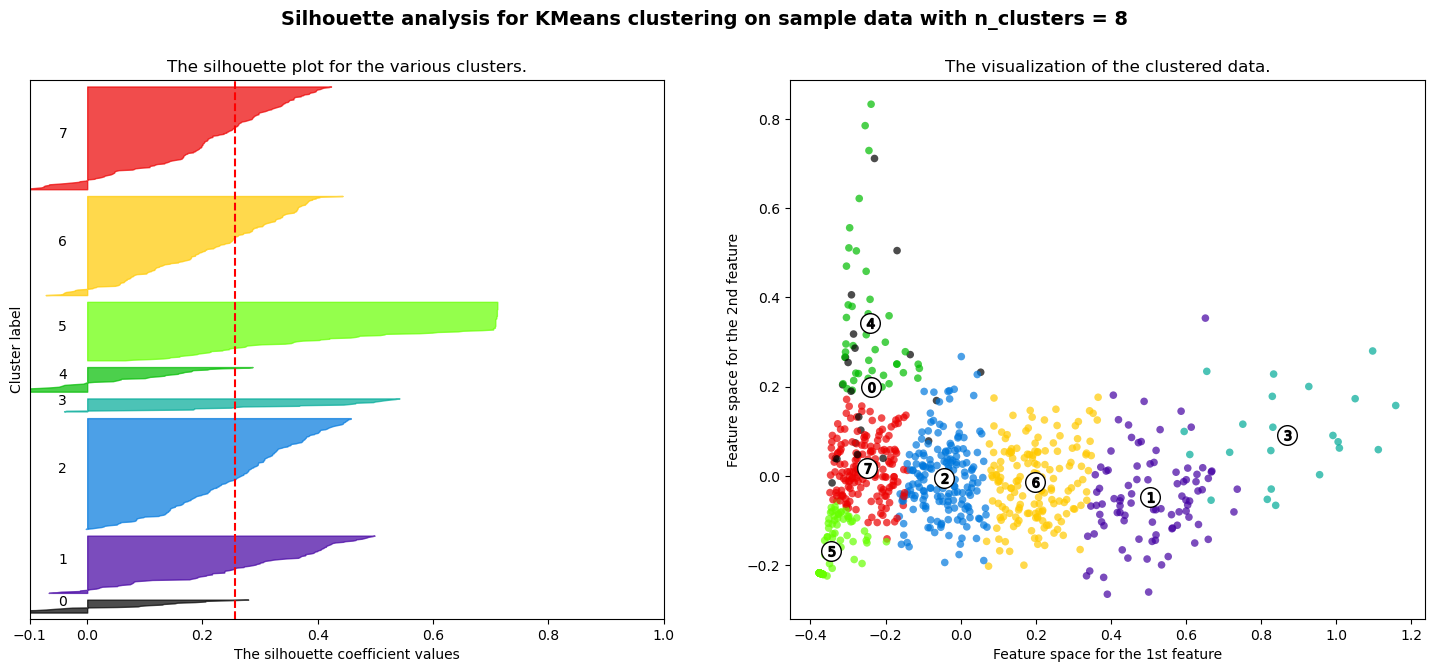

In [9]:
plot_silhoutte(X_fw, [2, 3, 4, 5, 6, 7, 8])

While fitting the data with 2 clusters had the highest silhouette score, it doesn't necessarily means it is the best k value to fit the data with. k = 3 had the next best silhoutte score and it fits the data better, aligning with the analysis from the elbow method plot. Although none of the k values high degrees of cohesion or seperation in each of the clusters

In [10]:
clusterer = KMeans(random_state=1, init="k-means++", n_clusters=3)
fw_labels = clusterer.fit_predict(X_fw)

In [11]:
(fw_data
 .query("pos == 'FW'")
[fw_cols]
 [fw_labels == 0]
).mean()

90s       3.521053
sh/90     2.162807
sot/90    0.705965
gls       0.726817
npxg      0.920802
sca90     2.443258
gca90     0.239173
dtype: float64

In [12]:
(fw_data
 .query("pos == 'FW'")
[fw_cols]
 [fw_labels == 1]
).mean()

90s       27.828440
sh/90      2.722661
sot/90     1.108991
gls       12.697248
npxg      10.338532
sca90      3.172936
gca90      0.402936
dtype: float64

In [13]:
(fw_data
 .query("pos == 'FW'")
[fw_cols]
 [fw_labels == 2]
).mean()

90s       15.982734
sh/90      2.267050
sot/90     0.851115
gls        4.478417
npxg       4.161151
sca90      2.876331
gca90      0.354065
dtype: float64

The above shows the mean stats of players in different clusters. players in the first cluster played less 90 minutes than players in the second cluster and third cluster so they scored less goals than those players. Players in the third played the most 90 minutes than any other players and scored the most goals on average.